### **Setup**

In [1]:
import os
import sys

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Move to project root
PROJECT_ROOT = "/content/drive/MyDrive/rl4nlp"
os.chdir(PROJECT_ROOT)
# Make project importable
if PROJECT_ROOT not in sys.path:
  sys.path.append(PROJECT_ROOT)

### **Imports**

In [4]:
from data_utils.load_magpie import load_magpie
from data_utils.load_idioms_in_context import load_idioms_in_context
from data_utils.load_lidioms import load_lidioms

from model.labse import LaBSEEncoder

from experimentation.experiment1_monolingual import experiment1_monolingual
from experimentation.experiment2_crosslingual import experiment2_crosslingual
from experimentation.experiment3_lidioms import experiment3_lidioms

from experimentation.metrics import (
    cosine_sim,
    random_pair_similarity,
    pca_analysis,
)

from experimentation.plots import (
    plot_similarity_distributions,
    plot_precision_at_k,
    plot_pca,
    plot_aligned_vs_random,
    plot_difference_histogram,
    plot_pca_crosslingual,
    plot_literal_vs_idiomatic_difference,
    plot_pairwise_similarity_scatter,
)

import numpy as np


In [5]:
encoder = LaBSEEncoder()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### **Experiment 1: Monolingual Distinction (MAGPIE)**

In [6]:
print("\n=== Experiment 1: Monolingual Distinction (MAGPIE) ===")

df_magpie = load_magpie("data/magpie.tsv")

sentences = df_magpie["sentence"].tolist()
labels = df_magpie["usage"].values

emb_magpie = encoder.encode(sentences)

stats_exp1 = experiment1_monolingual(
  embeddings=emb_magpie,
  df_magpie=df_magpie,
)


=== Experiment 1: Monolingual Distinction (MAGPIE) ===


Batches:   0%|          | 0/1390 [00:00<?, ?it/s]


[Experiment 1] Starting monolingual analysis...
  Total samples: 44451
  Figurative: 34138
  Literal: 10313

[Step 1] Computing similarity distributions...
  Using N=1000 samples for similarity computation
  Figurative pairs (after removing self-matches): 998978
  Literal pairs (after removing self-matches): 999000
  Cross-usage pairs: 1000000

  Similarity means:
    Fig-Fig: 0.1449 ± 0.0900
    Lit-Lit: 0.1476 ± 0.0900
    Fig-Lit: 0.1327 ± 0.0847

[Step 2] Statistical significance tests...
  Fig vs Cross: U=538029794529.0, p=0.00e+00, d=0.140
  Lit vs Cross: U=544401571593.0, p=0.00e+00, d=0.170
  ✓ Sanity checks passed

[Step 3] Computing global Precision@k...
  Precision@1: 0.795
  Precision@5: 0.977
  Precision@10: 0.992

[Step 4] Computing Precision@k by usage...
  Figurative:
    Precision@1: 0.847
    Precision@5: 0.991
    Precision@10: 0.999
  Literal:
    Precision@1: 0.566
    Precision@5: 0.895
    Precision@10: 0.961

[Step 5] PCA analysis...
  Explained variance (PC1, 

In [7]:
print("\n--- Similarity means ---")
for k, v in stats_exp1["means"].items():
    print(f"{k}: {v:.3f}")

print("\n--- Effect sizes (Cohen's d) ---")
for k, v in stats_exp1["effect_sizes"].items():
    print(f"{k}: {v:.3f}")

print("\n--- Mann–Whitney tests ---")
for name, (u, p) in stats_exp1["statistics"].items():
    print(f"{name}: U={u:.1f}, p={p:.2e}")

print("\n--- Precision@k by usage ---")
for usage, vals in stats_exp1["precision_at_k_by_usage"].items():
    print(f"{usage}:")
    for k, v in vals.items():
        print(f"  Precision@{k}: {v:.3f}")

print("\n--- PCA / clustering ---")
print("Explained variance (PC1, PC2):",
      stats_exp1["pca"]["explained_variance"])
print("Total explained variance:",
      stats_exp1["pca"]["total_variance"])
print("Silhouette score:",
      f'{stats_exp1["pca"]["silhouette_score"]:.3f}')


--- Similarity means ---
fig_fig: 0.145
lit_lit: 0.148
fig_lit: 0.133

--- Effect sizes (Cohen's d) ---
d_fig: 0.140
d_lit: 0.170

--- Mann–Whitney tests ---
fig_vs_cross: U=538029794529.0, p=0.00e+00
lit_vs_cross: U=544401571593.0, p=0.00e+00

--- Precision@k by usage ---
figurative:
  Precision@1: 0.847
  Precision@5: 0.991
  Precision@10: 0.999
literal:
  Precision@1: 0.566
  Precision@5: 0.895
  Precision@10: 0.961

--- PCA / clustering ---
Explained variance (PC1, PC2): [0.02729596 0.02020569]
Total explained variance: 0.047501646
Silhouette score: 0.002


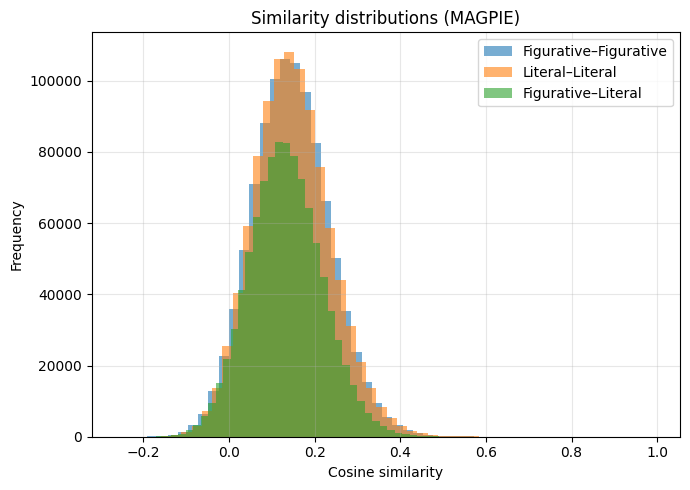

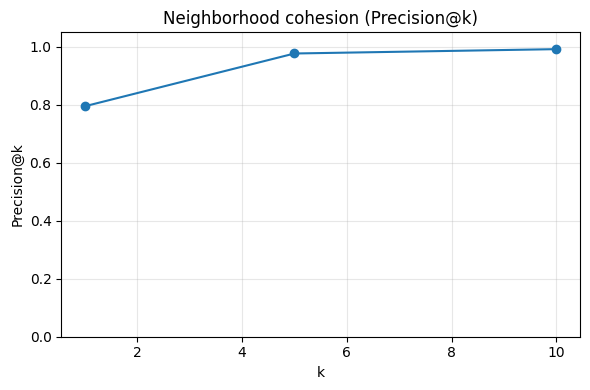

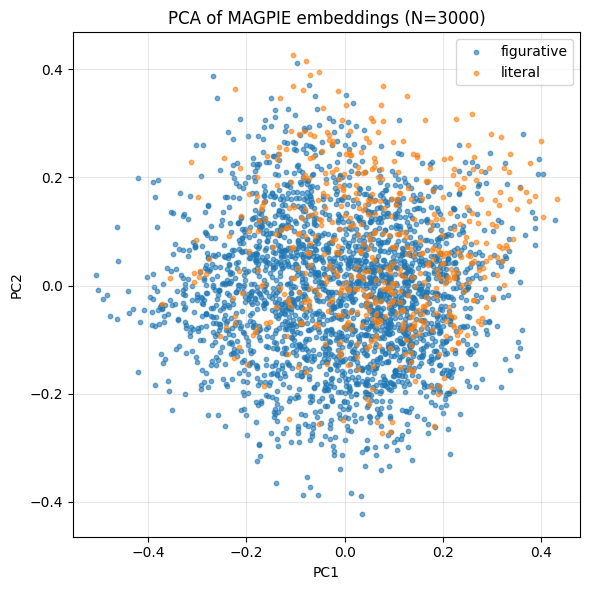

In [8]:
# Similarity distributions

plot_similarity_distributions(
  stats_exp1["similarities"]["fig"],
  stats_exp1["similarities"]["lit"],
  stats_exp1["similarities"]["cross"],
)

# Precision@k
plot_precision_at_k(stats_exp1["precision_at_k"])

# PCA
from experimentation.metrics import pca_analysis

N_PCA = 3000

emb_pca = emb_magpie[:N_PCA]
labels_pca = labels[:N_PCA]

pca = pca_analysis(emb_pca)
plot_pca(
  pca["X_proj"],
  labels=labels_pca,
  title="PCA of MAGPIE embeddings (N=3000)"
)

### **Experiment 2: Cross-lingual Alignment**

In [9]:
print("\n=== Experiment 2: Cross-lingual Alignment ===")

df_idioms = load_idioms_in_context(
  ru_path="data/idioms_in_context-test.ruru-enus.ruru",
  en_path="data/idioms_in_context-test.ruru-enus.enus",
)

emb_ru = encoder.encode(df_idioms["ru_sentence"].tolist())
emb_en = encoder.encode(df_idioms["en_sentence"].tolist())

stats_exp2 = experiment2_crosslingual(
    emb_ru=emb_ru,
    emb_en=emb_en,
    sentences_ru=df_idioms["ru_sentence"].tolist(),
    sentences_en=df_idioms["en_sentence"].tolist(),
)



=== Experiment 2: Cross-lingual Alignment ===


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]


[Experiment 2] Starting cross-lingual analysis...
  Total sentence pairs: 1000

[Step 1] Computing LaBSE similarity distributions...
  Aligned similarity: 0.7927 ± 0.0770
  Random similarity: 0.1724 ± 0.0908
  Difference: 0.6204

[Step 2] Statistical significance tests...
  Mann-Whitney U: 998820.0, p=0.00e+00
  Cohen's d: 7.366
  ✓ Sanity checks passed

[Step 3] Translation retrieval accuracy...
  Precision@1: 1.000
  Precision@5: 1.000
  Precision@10: 1.000
  ✓ Retrieval sanity check passed

[Step 4] Computing TF-IDF baseline...
  TF-IDF vocabulary size: 20000
  TF-IDF aligned: 0.0011 ± 0.0098
  TF-IDF random: 0.0000 ± 0.0000

  Comparison (LaBSE vs TF-IDF):
    LaBSE aligned: 0.7927
    TF-IDF aligned: 0.0011
    Ratio: 754.7x
  ✓ LaBSE substantially outperforms TF-IDF

[Step 5] Cross-lingual PCA analysis...
  Explained variance (PC1, PC2): [0.03631205 0.02319129]
  Total variance: 0.0595
  Silhouette score (PCA space): 0.3584
    (Low score indicates language-agnostic representati

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(
    df_idioms["ru_sentence"].tolist() +
    df_idioms["en_sentence"].tolist()
)

X_ru = X[:len(df_idioms)]
X_en = X[len(df_idioms):]

tfidf_sim = cosine_similarity(X_ru, X_en).diagonal()
tfidf_sim.mean()

np.float64(0.0012955078925551383)

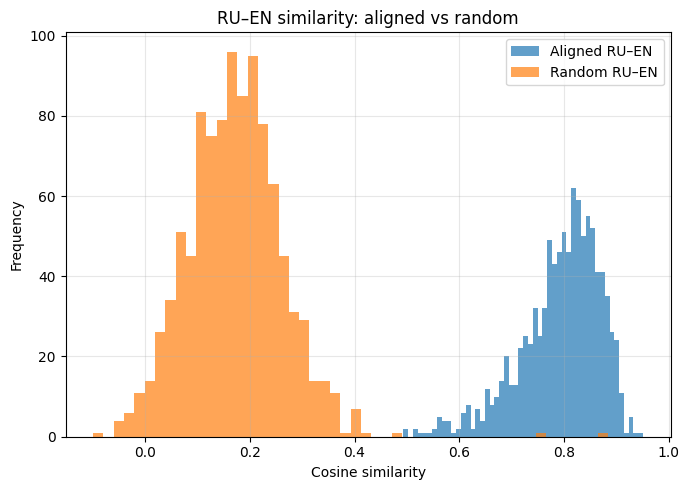

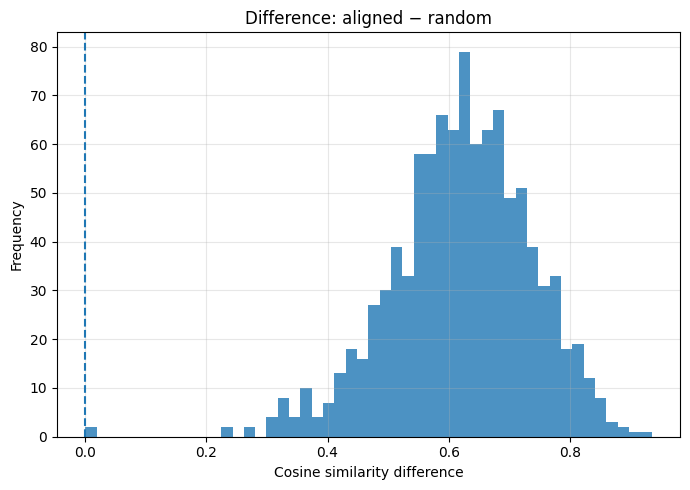

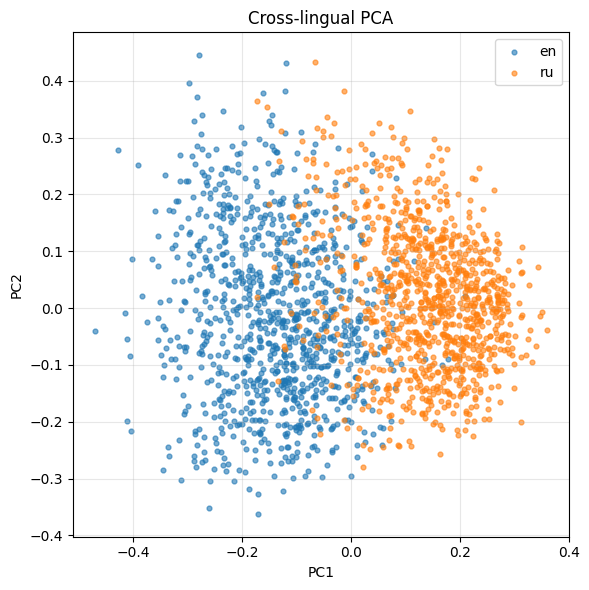

In [11]:
# Similarity distributions
aligned = cosine_sim(emb_ru, emb_en)
random = random_pair_similarity(emb_ru, emb_en)

plot_aligned_vs_random(
  aligned,
  random,
  title="RU–EN similarity: aligned vs random",
)

plot_difference_histogram(aligned, random)
# PCA (cross-lingual)
N_PCA = 1000
X = np.vstack([
  emb_ru[:N_PCA],
    emb_en[:N_PCA],
])

lang_labels = np.array(["ru"] * N_PCA + ["en"] * N_PCA)

pca = pca_analysis(X)
plot_pca_crosslingual(pca["X_proj"], lang_labels)

### **Experiment 3. Semantic vs Lexical Preference (LIdioms)**

In [12]:
print("\n=== Experiment 3: Semantic vs Lexical Preference (LIdioms)===")

df_lidioms = load_lidioms("data/lidioms_full.csv")

emb_ru = encoder.encode(df_lidioms["idiom_ru"].tolist())
emb_idiomatic = encoder.encode(df_lidioms["definition_en"].tolist())
emb_literal = encoder.encode(df_lidioms["literal_en"].tolist())

stats_exp3, detailed_exp3 = experiment3_lidioms(
  emb_ru=emb_ru,
  emb_idiomatic=emb_idiomatic,
  emb_literal=emb_literal,
  df_lidioms=df_lidioms,

)


=== Experiment 3: Semantic vs Lexical Preference (LIdioms)===


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
print("\n=== Experiment 3: Semantic vs Lexical Preference (LIdioms) ===")

print("\n--- Similarity means ---")
print(f"RU → EN definition: {stats_exp3['idiomatic_mean']:.3f}")
print(f"RU → EN literal:   {stats_exp3['literal_mean']:.3f}")

print("\n--- Preference analysis ---")
print(
    f"Mean difference (literal − idiomatic): "
    f"{stats_exp3['difference_mean']:.3f}"
)

print(
    f"Proportion preferring literal: "
    f"{stats_exp3['prop_prefers_literal']:.3f}"
)

print("\n--- Statistical test ---")
u_stat, p_value = stats_exp3["u_test"]
print(f"Mann–Whitney U = {u_stat:.1f}, p = {p_value:.2e}")
print(f"Cohen's d = {stats_exp3['cohens_d']:.3f}")


=== Experiment 3: Semantic vs Lexical Preference (LIdioms) ===

--- Similarity means ---
RU → EN definition: 0.361
RU → EN literal:   0.812

--- Preference analysis ---
Mean difference (literal − idiomatic): 0.452
Proportion preferring literal: 0.990

--- Statistical test ---
Mann–Whitney U = 10399.0, p = 5.40e-33
Cohen's d = 3.273


In [14]:
print("\n--- Detailed results (head) ---")
display(detailed_exp3.head())


--- Detailed results (head) ---


,idiom_ru,literal_en,definition_en,sim_idiomatic,sim_literal,difference,prefers_literal
0,вернемся к нашим баранам,return to our rams,let's return to our subject,0.744565,0.895208,0.150643,True
1,льёт как из ведра,pours like from a bucket,heavly rain,0.528424,0.843811,0.315387,True
2,водить за нос,lead by the nose,"fool, trick",0.357555,0.840246,0.482691,True
3,мастер на все руки,master of all hands,guy who can do everything (in a good way),0.510590,0.903256,0.392666,True
4,волосы дыбом,hairs upright,to make someone feel very frightened,0.298957,0.792407,0.493450,True


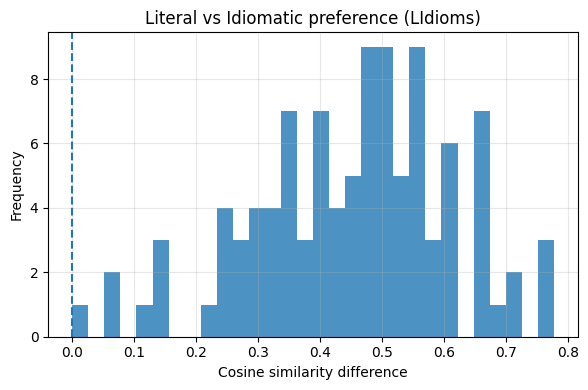

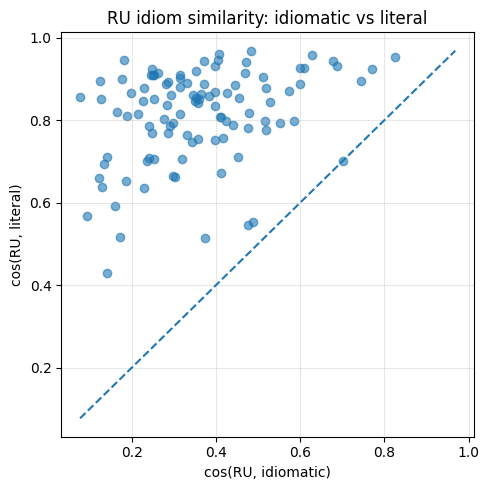

In [15]:
from experimentation.metrics import cosine_sim
from experimentation.metrics import cosine_sim

sim_idiomatic = cosine_sim(emb_ru, emb_idiomatic)
sim_literal = cosine_sim(emb_ru, emb_literal)

# Difference: literal − idiomatic
diff = sim_literal - sim_idiomatic

# --- Visualizations ---
from experimentation.plots import (
  plot_literal_vs_idiomatic_difference,
  plot_pairwise_similarity_scatter,
)

# 1) Histogram of differences (MAIN FIGURE)
plot_literal_vs_idiomatic_difference(
  diff,
  title="Literal vs Idiomatic preference (LIdioms)"
)

# 2) Pairwise scatter (SUPPORTING FIGURE)
plot_pairwise_similarity_scatter(
  sim_idiomatic,
  sim_literal,
  title="RU idiom similarity: idiomatic vs literal"
)

# **Summary table**

In [16]:
import pandas as pd

summary = pd.DataFrame({
    "Experiment": [
        "Exp1: Monolingual (Fig vs Cross)",
        "Exp1: Monolingual (Lit vs Cross)",
        "Exp2: Cross-lingual Alignment",
        "Exp3: Literal vs Idiomatic"
    ],
    "Main metric": [
        "Cohen's d",
        "Cohen's d",
        "Cohen's d",
        "Cohen's d"
    ],
    "Value": [
        stats_exp1["effect_sizes"]["d_fig"],
        stats_exp1["effect_sizes"]["d_lit"],
        stats_exp2["cohens_d"],
        stats_exp3["cohens_d"]
    ],
    "Interpretation": [
        "Weak separation",
        "Moderate separation",
        "Very strong alignment",
        "Literal preferred"
    ]
})

display(summary)

,Experiment,Main metric,Value,Interpretation
0,Exp1: Monolingual (Fig vs Cross),Cohen's d,0.139968,Weak separation
1,Exp1: Monolingual (Lit vs Cross),Cohen's d,0.170419,Moderate separation
2,Exp2: Cross-lingual Alignment,Cohen's d,7.365849,Very strong alignment
3,Exp3: Literal vs Idiomatic,Cohen's d,3.272766,Literal preferred


In [17]:
import pandas as pd

exp1_rows = [
    {
        "comparison": "fig_vs_cross",
        "mean_similarity": stats_exp1["means"]["fig_fig"],
        "cohens_d": stats_exp1["effect_sizes"]["d_fig"],
        "p_value": stats_exp1["statistics"]["fig_vs_cross"][1],
    },
    {
        "comparison": "lit_vs_cross",
        "mean_similarity": stats_exp1["means"]["lit_lit"],
        "cohens_d": stats_exp1["effect_sizes"]["d_lit"],
        "p_value": stats_exp1["statistics"]["lit_vs_cross"][1],
    },
]

df_exp1 = pd.DataFrame(exp1_rows)
df_exp1.to_csv("results/exp1_summary.csv", index=False)


In [18]:
df_exp2 = pd.DataFrame([{
    "aligned_mean": stats_exp2["aligned_mean"],
    "random_mean": stats_exp2["random_mean"],
    "cohens_d": stats_exp2["cohens_d"],
    "retrieval_p@1": stats_exp2["retrieval"][1],
    "retrieval_p@5": stats_exp2["retrieval"][5],
    "retrieval_p@10": stats_exp2["retrieval"][10],
    "tfidf_aligned_mean": stats_exp2.get("tfidf_aligned_mean"),
    "tfidf_random_mean": stats_exp2.get("tfidf_random_mean"),
}])

df_exp2.to_csv("results/exp2_summary.csv", index=False)


In [19]:
df_exp3 = pd.DataFrame([{
    "idiomatic_mean": stats_exp3["idiomatic_mean"],
    "literal_mean": stats_exp3["literal_mean"],
    "difference_mean": stats_exp3["difference_mean"],
    "prop_prefers_literal": stats_exp3["prop_prefers_literal"],
    "cohens_d": stats_exp3["cohens_d"],
    "p_value": stats_exp3["u_test"][1],
}])

df_exp3.to_csv("results/exp3_summary.csv", index=False)
